#

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import statsmodels.formula.api as smf
import patsy as pt
import warnings # cause pandas is ridiculous

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/refs/heads/master/finches.csv")

1.

In [3]:
model = smf.ols("winglength ~ island * beakwidth", data = df)
fit = model.fit()

1.

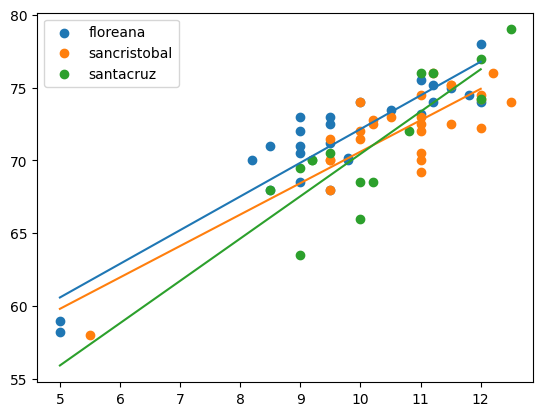

In [4]:
for name, gdf in df.groupby(["island"]):
    plt.scatter(gdf["beakwidth"], gdf["winglength"], label = name[0]);
    xnew = np.array([5, 12])
    ndf = pd.DataFrame.from_dict({"beakwidth": xnew, 
                              "island": [name[0], name[0]]})
    ndf["yhat"] = fit.predict(ndf)
    plt.plot(xnew, ndf["yhat"])
plt.legend();

1.

In [5]:
ndf = df \
    .groupby("island", as_index = False) \
    .aggregate(beakwidth = ("beakwidth", np.mean))

/var/folders/zp/6ns7k9bn1vs5cr99qc2xtdd00000gp/T/ipykernel_23633/295470535.py:3: FutureWarning: The provided callable <function mean at 0x1070342c0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .aggregate(beakwidth = ("beakwidth", np.mean))

In [6]:
fit.predict(ndf)

0    71.269231
1    72.029630
2    71.246667
dtype: float64

1.  

For extra credit (I’ll replace your worst quiz score with a perfect
score), either

1.  show why our function `bootstrap` isn’t compatible with
    `statsmodels`, or

2.  reuse our linear regression functions and `bootsrap` to answer

In either case, we’ll use our function `bootstrap`, so here it is.

In [8]:
def bootstrap(T, data, R = 1_000, conflevel = 0.95, **kwargs):
    shp = np.shape(T(data, **kwargs))
    rng = np.random.default_rng()
    Ts = np.zeros((R,) + shp)
    N = np.shape(data)[0]
    a = (1 - conflevel) / 2
    for r in range(R):
        idx = rng.integers(N, size = N)   
        Ts[r] = T(data[idx], **kwargs)
    return np.quantile(Ts, [a, 1 - a], axis = 0)    

1.  What we want to be able to do, is write a function that can be
    passed into our function `bootstrap` and have it just work. Here’s
    the idea, even if it doesn’t work.

In [7]:
def ll_regression_prediction(df, **kwargs):
    fit = smf.ols("winglength ~ island * beakwidth", data = df).fit()
    return fit.predict(kwargs["ndf"])

In [9]:
bootstrap(ll_regression_prediction, df, ndf = ndf)

This is the important bit of that annoyingly long error message,

`----> 9     Ts[r] = T(data[idx], **kwargs)`

We passed in `df` as the variable `data`. However, `pd.DataFrames` can’t
be directly indexed with numpy arrays of integers. They can only index
the “keys” of the columns’ names, e.g. `df["island"]`. Hence, this
errors.

1.  We can make our numpy based functions work, since numpy arrays can
    indeed be indexed directly with numpy arrays of integers. Let’s
    first set up our data. I’ll use `patsy` for this, since that’s what
    it is made for.

In [10]:
y, X = pt.dmatrices("winglength ~ island * beakwidth", data = df)
data = np.c_[y, X]

Here are our functions to fit linear regression.

In [21]:
def ll_regression(theta, data):
    X = data[:, 1:]
    y = data[:, 0]
    lm = np.sum(X * theta, axis = 1)
    return np.sum( (y - lm) ** 2 )
    
# ll_grad was for only two coefficients, but we have more.
# You can either not use it at all, like I've done below, or
# here's the gradient done in linear algebra.  You'll
# have to incorporate it yourself.
def ll_grad(theta, data):
    X = data[:, 1:]
    y = data[:, 0]
    return -2 * (y - X @ theta).T @ X

In [22]:
def ll_regression_prediction_minimize(data, **kwargs):
    rng = np.random.default_rng()
    init = rng.normal(size = np.shape(data[:, 1:])[1])
    o = minimize(ll_regression, init, args = (data,))
    return np.sum(o.x * np.array(kwargs["xnew"]), axis = 1) # axis = 1 is the only change

In [23]:
xnew = np.asarray(pt.dmatrix("~ island * beakwidth", data = ndf))

In [24]:
cis = bootstrap(ll_regression_prediction_minimize, data, xnew = xnew)

In [25]:
cis

array([[70.64136973, 71.33556734, 69.72060648],
       [72.02733426, 72.80993729, 72.39812768]])

To make this output a bit more obvious, I’ll put it into a dataframe.

In [26]:
cidf = pd.DataFrame(cis.T, columns = ["lower bound", "upper bound"])
cidf["island"] = ndf["island"]
cidf

1.  And here’s the easiest solution, which I wasn’t willing to announce,
    because it wasn’t worth any extra credit… unless of course you
    figured out how to do this without my telling you, then it’s worth
    extra credit.

Re-write bootstrap to accomodate both `pd.DataFrame`s and `np.ndarray`s.

In [27]:
def bootstrappp(T, data, R = 1_000, conflevel = 0.95, **kwargs):
    shp = np.shape(T(data, **kwargs))
    rng = np.random.default_rng()
    Ts = np.zeros((R,) + shp)
    N = np.shape(data)[0]
    a = (1 - conflevel) / 2
    for r in range(R):
        idx = rng.integers(N, size = N)   
        if isinstance(data, np.ndarray):
            Ts[r] = T(data[idx], **kwargs)
        else:
            Ts[r] = T(data.iloc[idx], **kwargs)
    return np.quantile(Ts, [a, 1 - a], axis = 0)    

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ci2 = bootstrappp(ll_regression_prediction, df, ndf = ndf)

In [29]:
ci2df = pd.DataFrame(ci2.T, columns = ["lower bound", "upper bound"])
ci2df["island"] = ndf["island"]
ci2df